# **NLP Task 3**

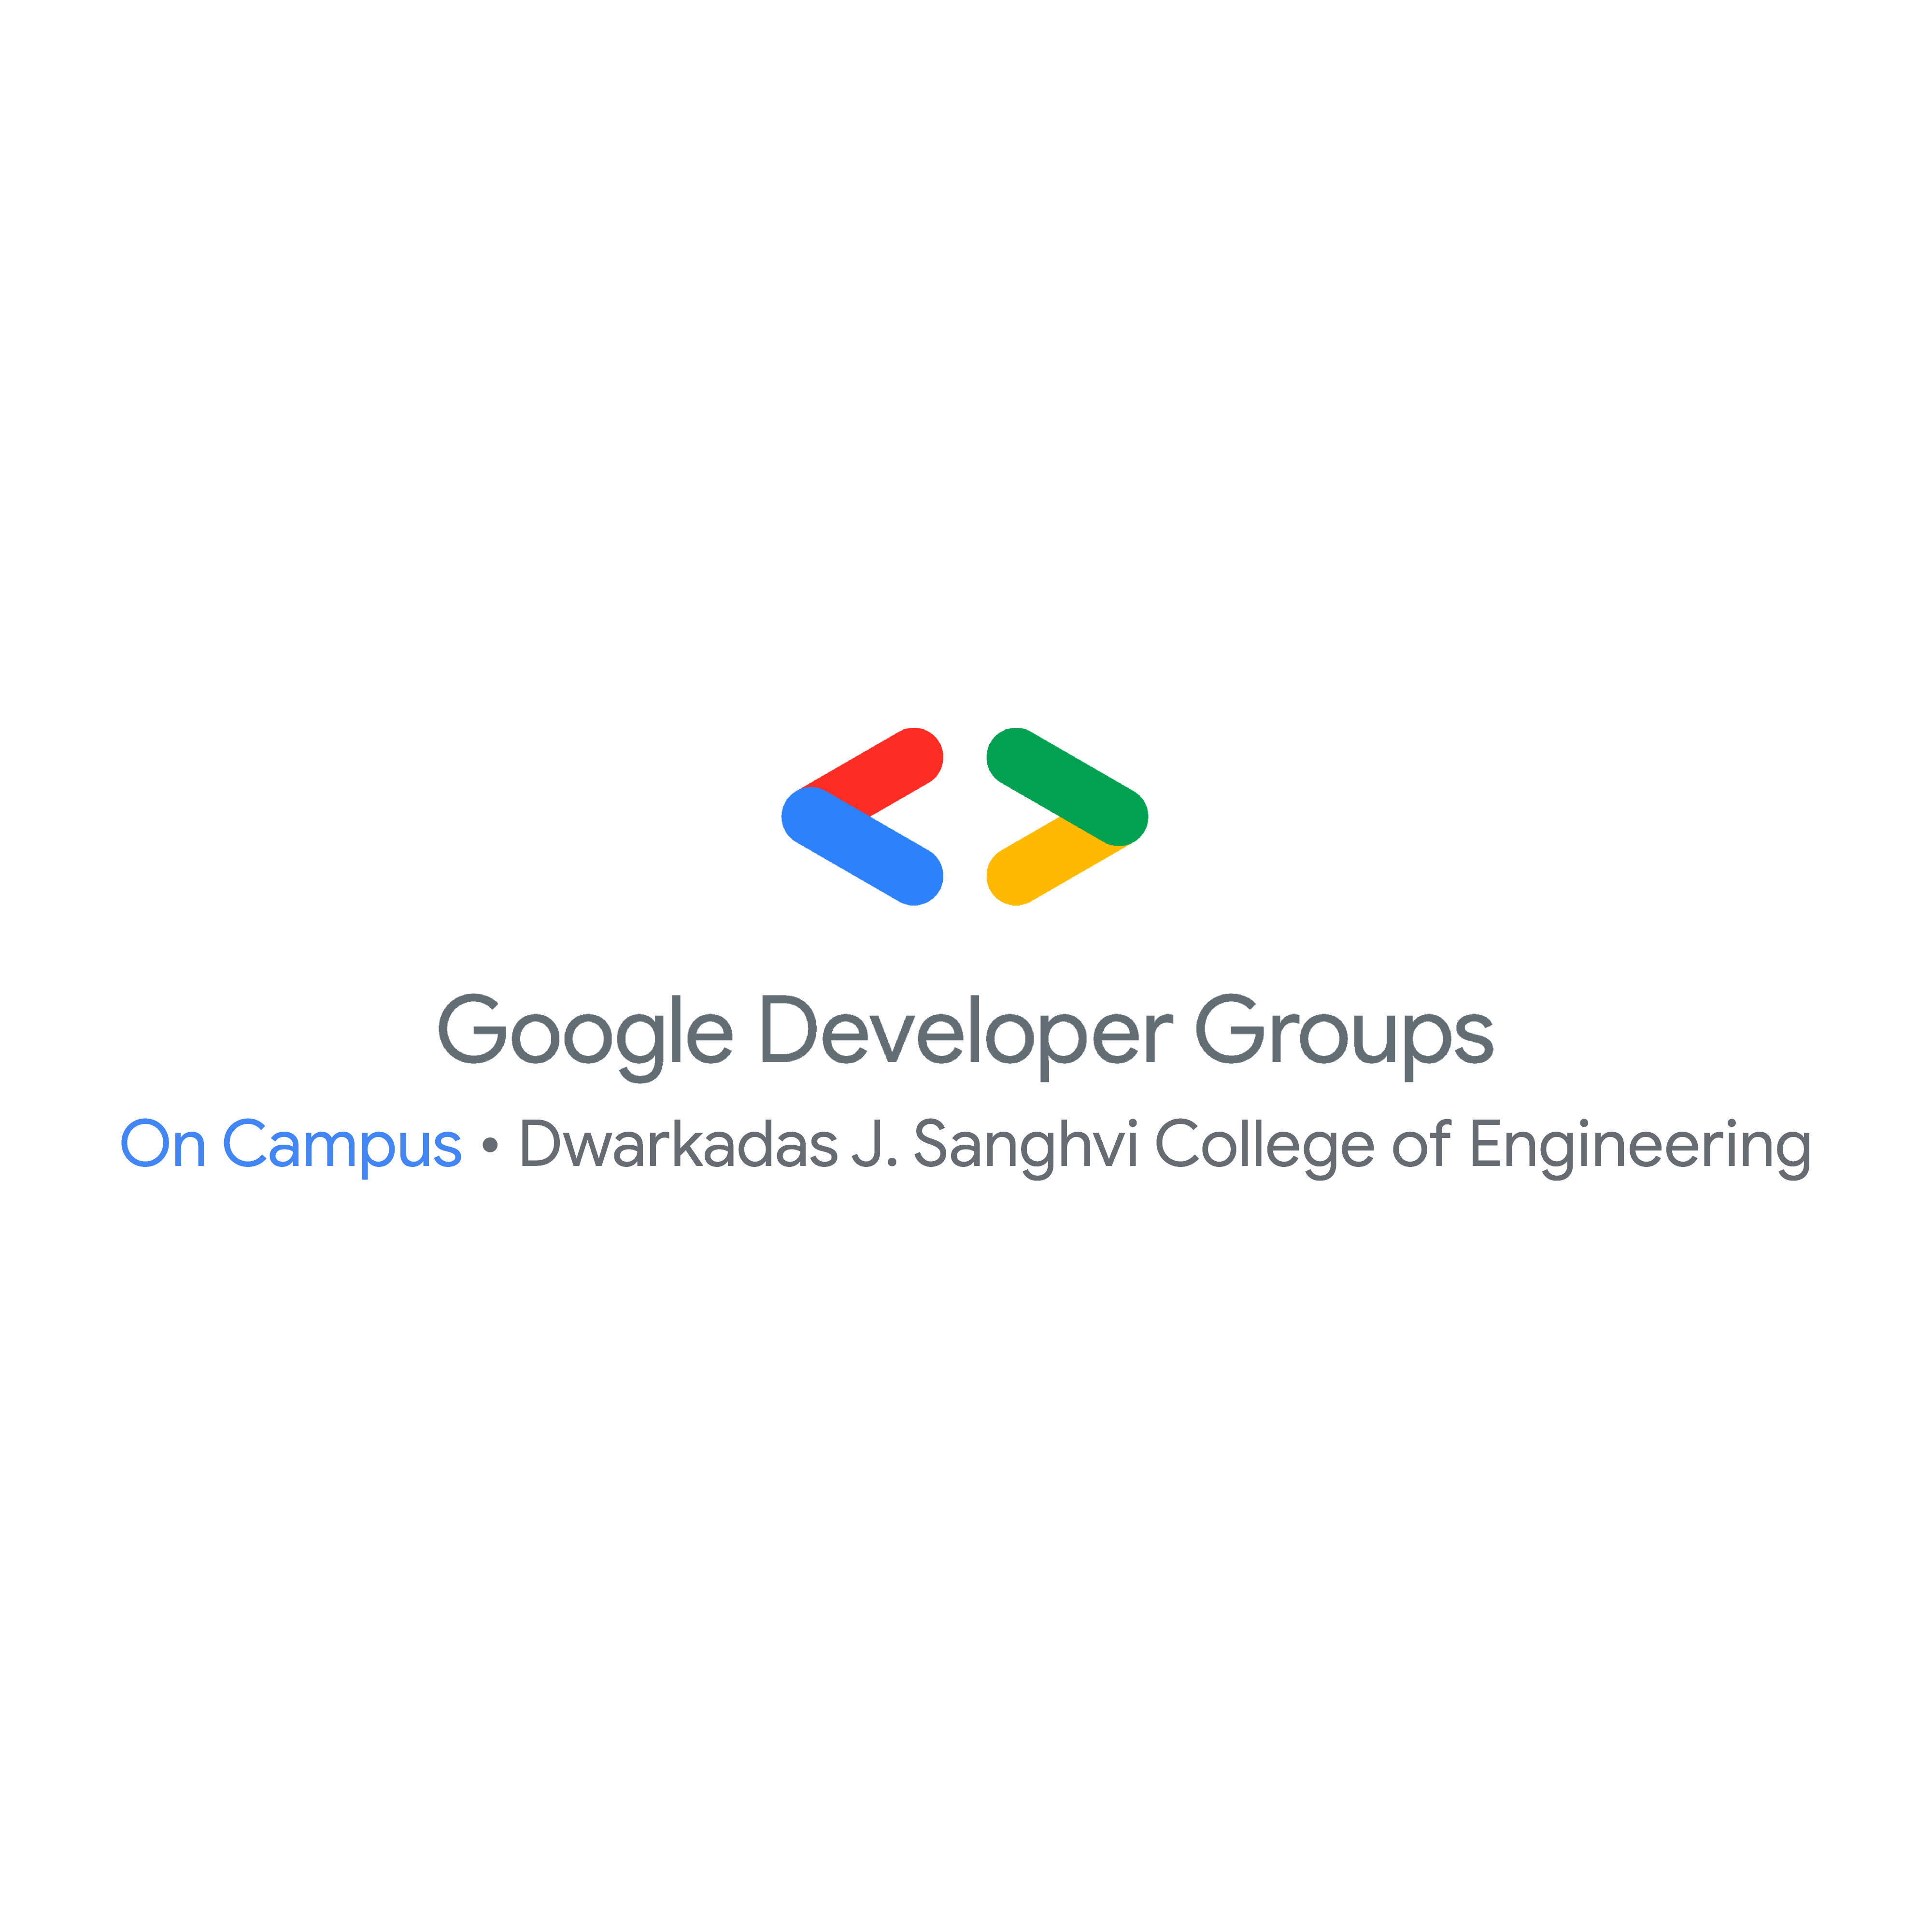


We have been exploring various Deep Learning techniques till now, and all of them somehow or the other through their shortcomings lead us to the architecture that shaped the future of NLP - the Transformer Model. Going further than its predecessor models, the Transformer architecture understands context in a way that other deep learning models like LSTM's and RNN's fail to do.

In this notebook, we will attempt to build a Transformer from scratch, particulary focusing on the Self Attention layer. A few things to note before we start:

1) This is not the **complete** and **latest** understanding of the Transformer architecture, implementing that is beyond the scope of any of us in this college as of now. This is an earlier iteration of the Attention Layer but is very much similar in its key concepts.

2) You might notice that not too many cells are given for you to complete in the Self Attention. This task is as much of understanding what is occuring in that code as it is a challenge to fill the blank sections of the code so that you don't feel overwhelmed but understand ki chal kya raha hai.

3) Don't fret if you feel overwhelmed by this, it IS difficult. Take your time, read up on resources and mainly focus on learning rather than just finishing off the task. Ok rant over

To get an idea of what we want to do and how we plan to get there, check these videos out: (StatQuest ftw):

Seq2Seq enc-dec neural networks - https://youtu.be/L8HKweZIOmg?si=lEqJj5RNRvuaOf-e

Attention in neural networks - https://youtu.be/PSs6nxngL6k?si=1NjFu2lyUhkVoIRW

Reviews.csv link download - https://drive.google.com/file/d/1T558yfJNALPogaILkbAvYO7C_P3qZEAT/view?usp=sharing

### Importing all the necessary libraries

In [78]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Attention, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.python.keras import backend as K
import gc
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Global Variables

These variables control key aspects of a language model for tasks like summarizing text. They set limits on input and output lengths (`max_len_text` and `max_len_summary`), determine how many times the model learns from the data (`epochs`), and specify the amount of data used (`number_of_datapoints`). The line `logger = tf.get_logger()` sets up a way to track the model's progress as it learns.

In [79]:
max_len_text=80
max_len_summary=10
epochs=10 ### PREFERABLY 50 must be done; for testing purposes use 10
number_of_datapoints=100000

logger = tf.get_logger()

Map contractions to their original phrase to make it easier to have a consistent representation of those terms and avoid mistakes in understanding context.

In [81]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

### Utility Data Preprocessing functions

In [52]:
def text_cleaner(text):
    newString = text.lower()  # Convert text to lowercase
    newString = BeautifulSoup(newString, "lxml").text  # Remove HTML tags
    newString = re.sub(r'\([^)]*\)', '', newString)  # Remove text inside parentheses
    newString = re.sub(r'"', ' ', newString)  # Replace double quotes with spaces

    # Split newString into words, contract them using contraction_mapping if needed, and join back into a string
    words = re.split(r'(\s+)', newString)  # Preserve spaces while splitting
    newString = ''.join(contraction_mapping.get(word, word) for word in words)

    newString = re.sub(r"'s\b", "", newString)  # Remove possessives like "dog's"
    newString = re.sub("[^a-zA-Z]", " ", newString)  # Remove non-alphabetic characters

    # Tokenization: return a list of words after removing stopwords
    tokens = newString.split()  # Split into words
    stop_words = set(stopwords.words('english'))  # Get stopwords list
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords

    long_words = []
    for i in tokens:
        if len(i) >= 3:  # Append only if length of word >= 3
            long_words.append(i)

    return " ".join(long_words).strip()  # Join words and remove extra spaces

In [82]:
def summary_cleaner(text):
    newString = re.sub(r'"', ' ', text)  # Replace occurrences of double quotes with a blank space

    # Split newString into words, contract them using contraction_mapping if needed, and join back into a string
    words = re.split(r'(\s+)', newString)  # Preserve spaces while splitting
    newString = ''.join(contraction_mapping.get(word, word) for word in words)

    newString = re.sub(r"'s\b", "", newString)  # Remove possessives like "dog's"
    newString = re.sub("[^a-zA-Z]", " ", newString)  # Remove non-alphabetic characters
    newString = newString.lower()  # Convert to lowercase

    tokens = newString.split()
    newString = ''
    for i in tokens:
        if len(i) > 1:  # Keep words longer than 1 character
            newString = newString + i + ' '
    
    return newString

### Data Preprocessing

In [83]:
data=pd.read_csv("/kaggle/input/review-dataset/Reviews.csv",nrows=number_of_datapoints)

In [84]:
data.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               6
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [85]:
#Drop duplicate values from the Text column
data = data.drop_duplicates(subset=['Text'])

#Drop null values from the dataset
data = data.dropna()

In [86]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [87]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text'] = cleaned_text
data['cleaned_summary'] = cleaned_summary

# Drop tuples where there is a blank value ('') in data['cleaned_summary']
data = data[data['cleaned_summary'] != '']

# Reset index after dropping rows
data = data.reset_index(drop=True)

In [88]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x: f"_START_ {x} _END_")

In [89]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

### Analysis of Sentence and Summary Length

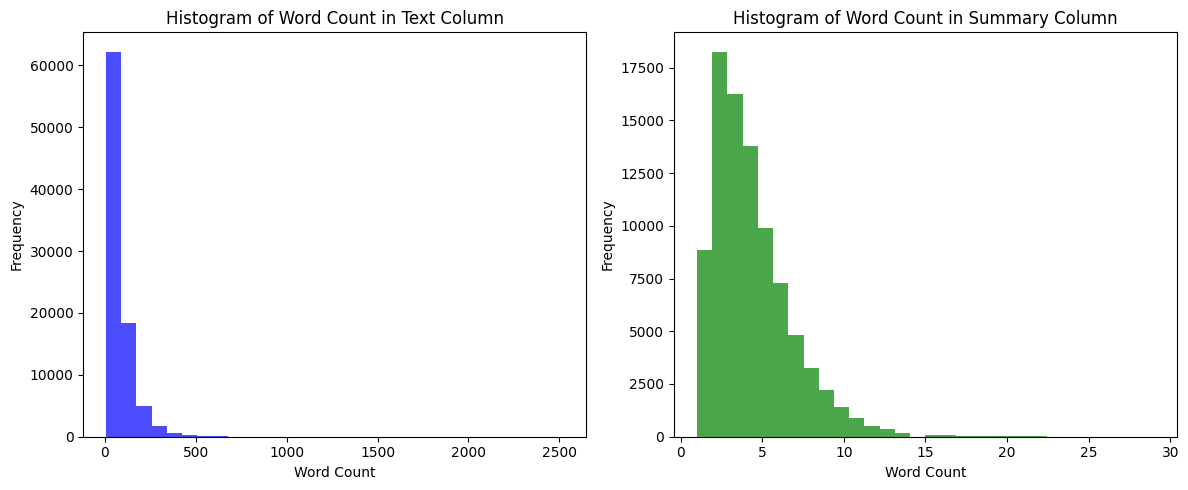

In [90]:
# Calculate word count for 'Text' and 'Summary' columns
text_word_count = data['Text'].apply(lambda x: len(str(x).split()))
summary_word_count = data['Summary'].apply(lambda x: len(str(x).split()))

# Plot histograms
plt.figure(figsize=(12, 5))

# Histogram for 'Text' word count
plt.subplot(1, 2, 1)
plt.hist(text_word_count, bins=30, color='blue', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count in Text Column')

# Histogram for 'Summary' word count
plt.subplot(1, 2, 2)
plt.hist(summary_word_count, bins=30, color='green', alpha=0.7)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count in Summary Column')

plt.tight_layout()
plt.show()

### Train-Test Split

In [91]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [92]:
#Create an instance of Tokenizer() and fit it on x_tr
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr)

#convert text sequences into integer sequences for x_tr and x_val
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

#Add padding as you have done in the past
x_max_len = max(len(seq) for seq in x_tr_seq)  # Find the longest sequence
x_tr_pad = pad_sequences(x_tr_seq, maxlen=x_max_len, padding='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=x_max_len, padding='post')

x_voc_size = len(x_tokenizer.word_index) + 1

In [93]:
#Create an instance of Tokenizer() and fit it on x_tr
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(y_tr)

#convert summary sequences into integer sequences for y_tr and y_val
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

#padding
y_max_len = max(len(seq) for seq in y_tr_seq)  # Find the longest sequence
y_tr_pad = pad_sequences(y_tr_seq, maxlen=y_max_len, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=y_max_len, padding='post')

y_voc_size = len(y_tokenizer.word_index) + 1

## Architecture

For the Attention Layer:
In Keras, it is easy to create a custom layer that implements attention by subclassing the Layer class. The Keras guide lists clear steps for creating a new layer via subclassing. You’ll use those guidelines here. All the weights and biases corresponding to a single layer are encapsulated by this class. You need to write the __init__ method as well as override the following methods:

build(): The Keras guide recommends adding weights in this method once the size of the inputs is known. This method “lazily” creates weights. The built-in function add_weight() can be used to add the weights and biases of the attention layer.

call(): The call() method implements the mapping of inputs to outputs. It should implement the forward pass during training.

Watch this videos to get an in-depth understanding - https://www.youtube.com/watch?v=fdhojC37_Co

https://www.youtube.com/watch?v=W2rWgXJBZhU

Read so that you understand and implement - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/

And Read the research paper cited below!!!! :D

https://arxiv.org/abs/1706.03762 and the paper in the docstring of the function

Don't break this code cell into smaller parts, as the tf.keras.backend.clear_session() would not be able to properly clear the session

In [94]:
tf.keras.backend.clear_session()

latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(None,))  # Input layer taking input size max_len_text
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)

# LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)  
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim, trainable=True)  # Similar to encoder embedding layer
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced: W_a, U_a, and V_a.
    """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)  # Inherit from tf.keras.layers.Layer

    def build(self, input_shape):
        assert isinstance(input_shape, list)

        # Define weight variables
        encoder_dim = input_shape[0][2]  # Hidden size of encoder
        decoder_dim = input_shape[1][2]  # Hidden size of decoder

        self.U_a = self.add_weight(name='U_a',
                                   shape=(decoder_dim, encoder_dim),
                                   initializer='uniform',
                                   trainable=True)

        self.W_a = self.add_weight(name='W_a',
                                   shape=(encoder_dim, encoder_dim),
                                   initializer='uniform',
                                   trainable=True)

        self.V_a = self.add_weight(name='V_a',
                                   shape=(encoder_dim, 1),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert isinstance(inputs, list)
        encoder_out_seq, decoder_out_seq = inputs

        def energy_step(inputs, states):
            """Computes energy score for each encoder state"""
            encoder_full_seq = states[0]  # Extract encoder outputs

            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)  
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  

            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)  
            e_i = K.softmax(e_i)  

            return e_i, [e_i]

        def context_step(inputs, states):
            """Computes context vector"""
            encoder_full_seq = states[0]  
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)  

            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)

        last_out, e_outputs, _ = K.rnn(energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq])

        last_out, c_outputs, _ = K.rnn(context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq])

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """Outputs produced by the layer"""
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Initialize and apply attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense output layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define and summarize the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 500)      │     25,844,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, None, 500),    │      2,002,000 │ embedding[0][0]        │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, None, 500),    │      2,002,000 │ lstm[0][0]             │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 500)      │      7,070,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, None, 500),    │      2,002,000 │ lstm_1[0][0]           │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 500),    │      2,002,000 │ embedding_1[0][0],     │
│                           │ (None, 500), (None,    │                │ lstm_2[0][1],          │
│                           │ 500)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ [(None, None, 500),    │        500,500 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, None)]    │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 1000)     │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 14140)    │     14,154,140 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,577,140 (212.01 MB)

 Trainable params: 55,577,140 (212.01 MB)

 Non-trainable params: 0 (0.00 B)

STATE YOUR UNDERSTANDING OF ATTENTION LAYER DESCRIPTIVELY :)

The **Attention Layer** in neural networks, particularly in sequence-to-sequence models, is a mechanism that allows the model to focus on relevant parts of the input sequence while generating each token of the output sequence. This is particularly useful in tasks like **machine translation, text summarization, and image captioning**, where different parts of the input contribute differently to each output step.

---

### **Understanding the Attention Mechanism**
The **Bahdanau Attention (Additive Attention)** used in the given code consists of the following steps:

#### **1. Problem with Traditional Seq2Seq Models**
- In standard **Encoder-Decoder architectures**, the encoder compresses the entire input sequence into a **single fixed-length context vector** (the final hidden state).
- However, this can lead to **information loss**, especially for long sequences.
- The decoder, when generating words, may struggle to retrieve specific information from the compressed context.

#### **2. How Attention Solves This Issue**
- Instead of using a single fixed-length context vector, **attention dynamically computes a weighted sum of all encoder hidden states** for each output step.
- This means the decoder can focus more on **relevant parts of the input sequence** instead of relying on a single summary.

In [95]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [96]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=epochs,batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

KeyError: 'key of type tuple not found and not a MultiIndex'

In [ ]:
gc.collect()

1622

### Post Training Analysis & Testing

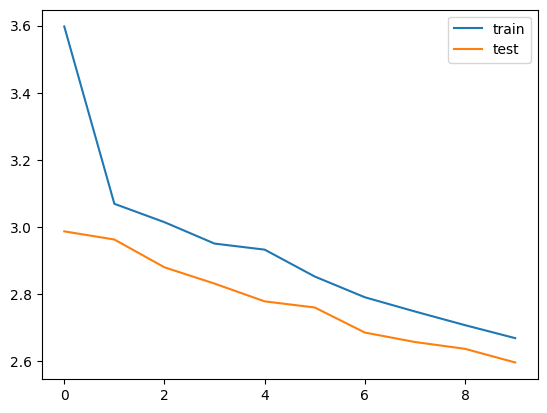

In [ ]:
#Plot loss and val_loss by extracting it from the history of the object


In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
#create a Model by specifying the inputs and the outputs (also consider h and c in output)
encoder_model =

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
#write a line similar for c

decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= #Use the decoder embedding layer you made above and pass decoder input to it

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = # create an attention layer with the help of decoder_hidden_state_input and decoder_outputs2
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary. Again, you have created this layer above, so use that
decoder_outputs2 =

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq =

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] =

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Write the code to predict the values of output_tokens, h, c based on our model

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index+1]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Write code for the Exit condition: either hit max length or find the 'end' word.
            if( ):
              stop_condition = True


        # Update the target sequence (of length 1).


        # Update internal states


    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    # write a code similar to that above, with some modifications in conditions


### Let's do some Generation

In [ ]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text))[:18])
print("\n")

Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
1/1 [==============================] - 0s 48ms/step
Predicted summary:  the wonderful of 




Exploring Bidirectional RNNs and the BiLSTM Architecture

Implementing a BiLSTM model for a specific NLP task (e.g., named entity recognition or sentiment analysis)
--